In [1]:
from google.colab import drive

drive.mount("/content/drive")

%cd '/content/drive/MyDrive/ckd_uae/'

!source /content/drive/MyDrive/ckd_env/bin/activate

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ckd_uae


In [2]:
# !pip install lifelines

# Modeling: CKD_UAE

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess

##################### import model libraries ###################################
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from lifelines import CoxPHFitter, KaplanMeierFitter
################################################################################

######################### import model metrics #################################
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
    brier_score_loss,
    confusion_matrix,
)

######################## import calibration techniques #########################
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

################################################################################

from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

from functions import *  # import custom functions

In [4]:
# paths to files
data_original = "/content/drive/MyDrive/ckd_uae/data/df_original/"
data_years = "/content/drive/MyDrive/ckd_uae/data/df_years/"
data_eda = "/content/drive/MyDrive/ckd_uae/data/df_eda/"
image_path = "/content/drive/MyDrive/ckd_uae/images/"

In [5]:
# save out the split datasets to separate parquet files
X_train = pd.read_parquet(os.path.join(data_original, "X_train.parquet"))
X_test = pd.read_parquet(os.path.join(data_original, "X_test.parquet"))
y_train = pd.read_parquet(os.path.join(data_original, "y_train.parquet"))
y_test = pd.read_parquet(os.path.join(data_original, "y_test.parquet"))
df_train = pd.read_parquet(os.path.join(data_original, "df_train.parquet"))
df_test = pd.read_parquet(os.path.join(data_original, "df_test.parquet"))
df = pd.read_parquet(os.path.join(data_original, "df_original.parquet"))
df_eda = pd.read_parquet(os.path.join(data_eda, "df_eda.parquet"))

In [6]:
## CPH-related joins to parse in "time_years" column and drop "time_months" col.
cph_train = df_train.join(df_eda["time_years"], on="id", how="inner").drop(
    columns=["time_months"]
)
cph_test = df_test.join(df_eda["time_years"], on="id", how="inner").drop(
    columns=["time_months"]
)

## Cox Proportional Hazards (CPH) Model

In [7]:
# Instantiate the CoxPHFitter
cph = CoxPHFitter(
    baseline_estimation_method="breslow",
)

# Fit the model with additional options for the optimization routine
cph.fit(
    cph_train,
    duration_col="time_years",
    event_col="outcome",
    weights_col="creatinine",
    robust=True,
    show_progress=True,
)

Iteration 1: norm_delta = 9.93e-01, step_size = 0.9500, log_lik = -107046.54058, newton_decrement = 5.73e+03, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.95e-01, step_size = 0.9500, log_lik = -102616.29589, newton_decrement = 5.67e+02, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.22e-02, step_size = 0.9500, log_lik = -102088.67088, newton_decrement = 2.94e+00, seconds_since_start = 0.1
Iteration 4: norm_delta = 2.30e-04, step_size = 1.0000, log_lik = -102085.71877, newton_decrement = 2.18e-04, seconds_since_start = 0.1
Iteration 5: norm_delta = 2.08e-08, step_size = 1.0000, log_lik = -102085.71855, newton_decrement = 2.91e-12, seconds_since_start = 0.1
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 70882.7 total observations, 61087.7 right-censored observations>

In [8]:
# To evaluate the model, we will use the predict method on the test set and then
# calculate the concordance index
cph_train_score = cph.score(cph_train, scoring_method="concordance_index")
cph_validation_score = cph.score(cph_train, scoring_method="concordance_index")

cph_train_score, cph_validation_score

(0.7851420554191512, 0.7851420554191512)

In [9]:
# print the summary of the model
# Print the summary of the model
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 70882.7 total observations, 61087.7 right-censored observations>
             duration col = 'time_years'
                event col = 'outcome'
              weights col = 'creatinine'
          robust variance = True
      baseline estimation = breslow
   number of observations = 70882.7
number of events observed = 9795
   partial log-likelihood = -102085.72
         time fit was run = 2024-03-23 01:48:03 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
sex                      0.09       1.10       0.30            -0.50             0.68                 0.61                 1.98
cancer                   0.62       1.85       0.33            -0.02             1.25                 0.98                 3.50
smoking                  0.09       1.09       0.28            -0.46             0.64                 0.63                 1.90
obesity                 -0.71       0.49       0.25            -1.21            -0.22                 0.30                 0.81
hypertension             0.87       2.39       0.42             0.05             1.70                 1.05                 5.46
dyslipidemia            -1.10       0.33       0.42            -1.91            -0.28                 0.15                 0.76
diabetes                 0.57       1.76       0.30            -0.01             1.15                 0.99                 3.15
cardiovascular_disease   1.39       4.00       0.26             0.89             1.89                 2.43                 6.60

                         cmp to     z      p   -log2(p)
covariate                                              
sex                        0.00  0.31   0.75       0.41
cancer                     0.00  1.89   0.06       4.08
smoking                    0.00  0.32   0.75       0.41
obesity                    0.00 -2.81 <0.005       7.65
hypertension               0.00  2.07   0.04       4.70
dyslipidemia               0.00 -2.63   0.01       6.86
diabetes                   0.00  1.91   0.06       4.17
cardiovascular_disease     0.00  5.44 <0.005      24.13
---
Concordance = 0.79
Partial AIC = 204187.44
log-likelihood ratio test = 9921.64 on 8 df
-log2(p) of ll-ratio test = inf

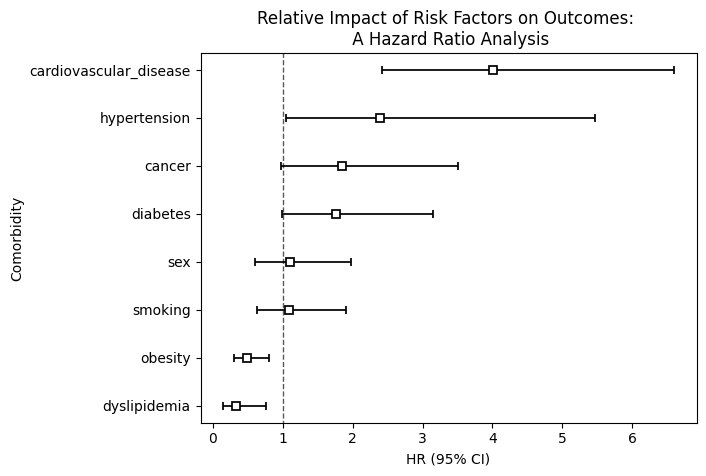

In [10]:
# Plot the results of the cph model with hazards ratios
cph.plot(hazard_ratios=True)
plt.title("Relative Impact of Risk Factors on Outcomes: \n A Hazard Ratio Analysis")
plt.ylabel("Comorbidity")
plt.savefig(os.path.join(image_path, "cph_hazard_ratios.svg"))
plt.show()

### Kaplan-Meier Estimates

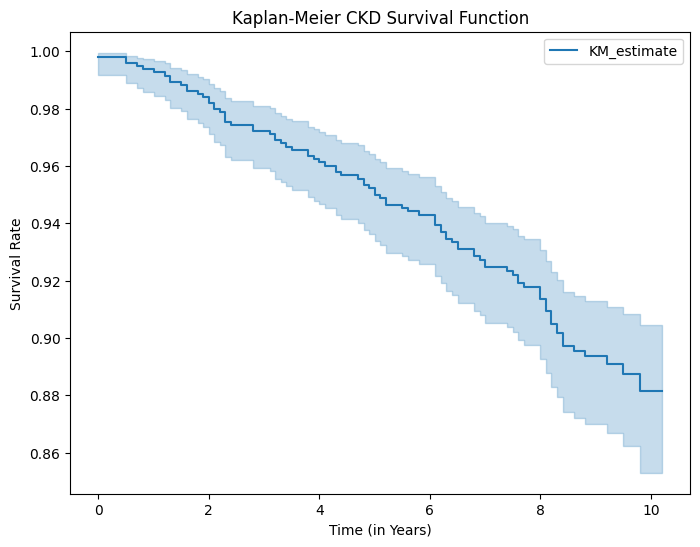

In [11]:
# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the data
kmf.fit(durations=cph_train["time_years"], event_observed=cph_train["outcome"])

# Plot the Kaplan-Meier estimate of the survival function
kmf.plot_survival_function(figsize=(8,6))

plt.title("Kaplan-Meier CKD Survival Function")
plt.xlabel("Time (in Years)")
plt.ylabel("Survival Rate")
plt.savefig(os.path.join(image_path, "kaplan_meier.svg"))
plt.show()  # Show the plot

### Partial Effects on Outcome

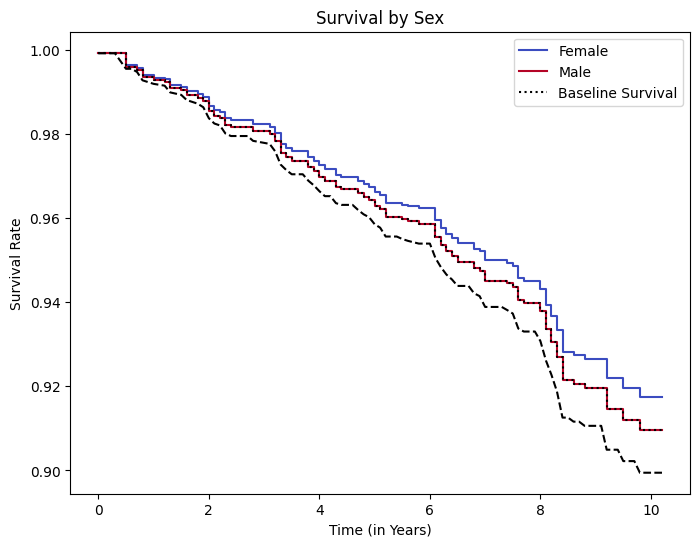

In [12]:
covariate = "sex"
# Then you define the values of the covariate you're interested in examining.
# For instance, if 'age' ranges from 20 to 70, you might choose a few key values within this range
values_of_interest = [0, 1]
labels = ["Female", "Male"]

# Generate the plot
ax = cph.plot_partial_effects_on_outcome(
    covariates=covariate, values=values_of_interest, cmap="coolwarm"
)

# Change the figure size here by accessing the figure object that 'ax' belongs to
ax.figure.set_size_inches(8, 6)

# Plot the baseline survival
cph.baseline_survival_.plot(
    ax=ax, color="black", linestyle="--", label="Baseline Survival"
)

# Manually construct the labels list including the baseline survival
labels_with_baseline = labels + ["Baseline Survival"]

# Retrieve the lines that have been plotted (which correspond to 'values_of_interest')
lines = ax.get_lines()

ax.set_title("Survival by Sex")
ax.set_xlabel("Time (in Years)")
ax.set_ylabel("Survival Rate")
ax.legend(lines, labels_with_baseline)  # Update the legend to include all lines
plt.savefig(os.path.join(image_path, "partial_effects_on_outcomes.svg"))
plt.show()  # Show the plot

## Customized Machine Learning Algorithms

In [13]:
rstate = 222  # random state for reproducibility

In [14]:
# untuned models
# lr = LogisticRegression(class_weight="balanced", random_state=rstate)
# svm = SVC(class_weight="balanced", probability=True, random_state=rstate)
# rf = RandomForestClassifier(class_weight="balanced", random_state=rstate)
# et = ExtraTreesClassifier(class_weight="balanced", random_state=rstate)

In [15]:
# Define pipelines and parameter grids for each model
# Pipelines define a sequence of data processing steps followed by a model
# Each pipeline begins with feature scaling using StandardScaler to standardize
# the data

# Logistic regression with balanced class weight
# Standardize features by removing the mean and scaling to unit variance
pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),  # Standardize features
    ("lr", LogisticRegression(class_weight="balanced", random_state=rstate)),
])

# SVM with balanced class weight
pipeline_svm = Pipeline([
    ("scaler", StandardScaler()),  # Standardize features
    ("svm", SVC(class_weight="balanced", probability=True, random_state=rstate)),
])

# Random forest with balanced class weight
pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),  # Standardize features
    ("rf", RandomForestClassifier(class_weight="balanced", random_state=rstate)),
])

# Define the Extra Trees pipeline; Extra Trees with balanced class weight
pipeline_et = Pipeline([
    ("scaler", StandardScaler()),  # Standardize features
    ("et", ExtraTreesClassifier(class_weight="balanced", random_state=rstate)),
])

# Define the parameter grids for each model. The keys are prefixed with the
# model's name from the pipeline followed by a double underscore to specify
# parameter names for hyperparameter tuning.

# Parameter grid for the Logistic Regression model
param_grid_lr = {
    "lr__C": [0.001, 0.01, 0.1, 1, 10],  # Inverse of regularization strength
    "lr__solver": ["liblinear", "saga"],  # Algorithm in the optimization problem
    "lr__n_jobs": [-1],  # Number of CPU cores used when parallelizing over classes
}

# Parameter grid for the SVM model
param_grid_svm = {
    "svm__C": [0.1, 1, 10],  # Penalty parameter C of the error term
    "svm__kernel": ["linear", "poly", "rbf", "sigmoid"],  # kernel type
}

# Parameter grid for the Random Forest model
param_grid_rf = {
    "rf__n_estimators": [50, 100, 200, 500],  # The number of trees in the forest
    "rf__max_depth": [None, 10, 20, 30],  # The maximum depth of the tree
    "rf__min_samples_split": [2, 5, 10],  # min no. of samp. to split internal node
    "rf__n_jobs": [-1],  # The number of jobs to run in parallel
}

# Parameter grid for the Extra Trees model
param_grid_et = {
    "et__n_estimators": [200, 500, 1000],  # The number of trees in the forest
    "et__max_depth": [None, 10, 20, 30],  # The maximum depth of the tree
    "et__min_samples_split": [2, 5, 10],  # min no. of samp. to split internal node
    "et__n_jobs": [-1],  # The number of jobs to run in parallel
}

# GridSearchCV is set up for each model, defining cross-validation (cv) strategy,
# scoring metric, and verbosity
grid_search_lr = GridSearchCV(
    pipeline_lr,
    param_grid_lr,
    cv=5,
    scoring="accuracy",
    verbose=1,
)
grid_search_svm = GridSearchCV(
    pipeline_svm,
    param_grid_svm,
    cv=5,
    scoring="accuracy",
    verbose=1,
)
grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,
    scoring="accuracy",
    verbose=1,
)
grid_search_et = GridSearchCV(
    pipeline_et,
    param_grid_et,
    cv=5,
    scoring="accuracy",
    verbose=1,
)

### Fitting Models Without Calibration

In [16]:
model_list = [
    ("grid_search_lr", grid_search_lr),
    ("grid_search_svm", grid_search_svm),
    ("grid_search_rf", grid_search_rf),
    ("grid_search_et", grid_search_et),
]

non_calibrated_probas_dict = {}

for name, model in tqdm(model_list, desc="Fitting models"):
    print(f"\nFitting {name}...")
    model.fit(
        X_train, y_train
    )  # This fits GridSearchCV which in turn finds the best estimator
    print(f"\nBest parameters for {name}: \n{model.best_params_}")

    # Predictions and probabilities from the calibrated model
    model_scores = model.predict(X_test)
    model_probas = model.predict_proba(X_test)[:, 1]

    # Storing scores and probabilities in probas_dict
    non_calibrated_probas_dict[name + "_score"] = model_scores
    non_calibrated_probas_dict[name + "_proba"] = model_probas

Fitting models:   0%|          | 0/4 [00:00<?, ?it/s]


Fitting grid_search_lr...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


Fitting models:  25%|██▌       | 1/4 [00:02<00:06,  2.28s/it]


Best parameters for grid_search_lr: 
{'lr__C': 0.1, 'lr__n_jobs': -1, 'lr__solver': 'saga'}

Fitting grid_search_svm...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Fitting models:  50%|█████     | 2/4 [00:18<00:20, 10.49s/it]


Best parameters for grid_search_svm: 
{'svm__C': 0.1, 'svm__kernel': 'poly'}

Fitting grid_search_rf...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


Fitting models:  75%|███████▌  | 3/4 [02:51<01:15, 75.61s/it]


Best parameters for grid_search_rf: 
{'rf__max_depth': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 50, 'rf__n_jobs': -1}

Fitting grid_search_et...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


Fitting models: 100%|██████████| 4/4 [07:06<00:00, 106.54s/it]


Best parameters for grid_search_et: 
{'et__max_depth': None, 'et__min_samples_split': 2, 'et__n_estimators': 200, 'et__n_jobs': -1}


### Fitting Models With Calibration

In [17]:
calibrated_models = {}
probas_dict = {}

for name, model in tqdm(model_list, desc="Fitting models"):
    print(f"\nFitting {name}...")
    model.fit(
        X_train, y_train
    )  # This fits GridSearchCV which in turn finds the best estimator
    print(f"\nBest parameters for {name}: \n{model.best_params_}")

    # Create a calibrated classifier from the best estimator of the grid search
    calibrated_clf = CalibratedClassifierCV(
        model.best_estimator_,
        method="isotonic",
        cv=5,
    ).fit(X_train, y_train)

    # Store the calibrated model for potential later use
    calibrated_models[name] = calibrated_clf

    # Predictions and probabilities from the calibrated model
    model_scores = calibrated_clf.predict(X_test)
    model_probas = calibrated_clf.predict_proba(X_test)[:, 1]

    # Storing scores and probabilities in probas_dict
    probas_dict[name + "_score"] = model_scores
    probas_dict[name + "_proba"] = model_probas

Fitting models:   0%|          | 0/4 [00:00<?, ?it/s]


Fitting grid_search_lr...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


Fitting models:  25%|██▌       | 1/4 [00:01<00:03,  1.22s/it]


Best parameters for grid_search_lr: 
{'lr__C': 0.1, 'lr__n_jobs': -1, 'lr__solver': 'saga'}

Fitting grid_search_svm...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters for grid_search_svm: 
{'svm__C': 0.1, 'svm__kernel': 'poly'}


Fitting models:  50%|█████     | 2/4 [00:09<00:10,  5.27s/it]


Fitting grid_search_rf...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters for grid_search_rf: 
{'rf__max_depth': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 50, 'rf__n_jobs': -1}


Fitting models:  75%|███████▌  | 3/4 [02:45<01:14, 74.19s/it]


Fitting grid_search_et...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters for grid_search_et: 
{'et__max_depth': None, 'et__min_samples_split': 2, 'et__n_estimators': 200, 'et__n_jobs': -1}


Fitting models: 100%|██████████| 4/4 [07:12<00:00, 108.13s/it]


### Calibration Curves

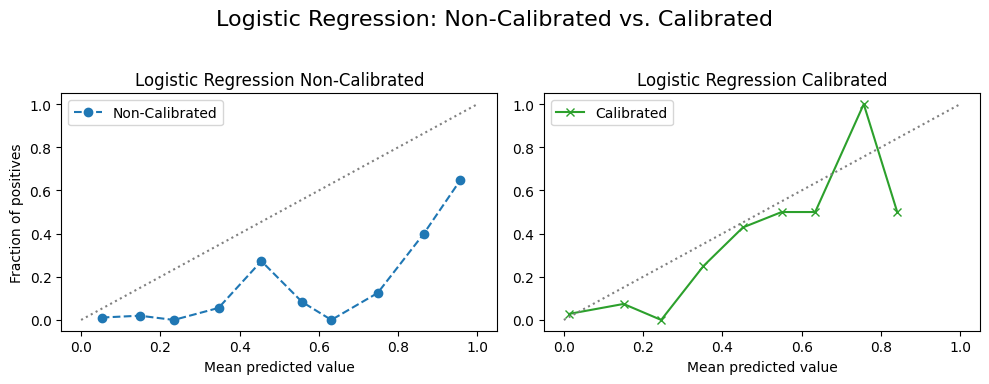

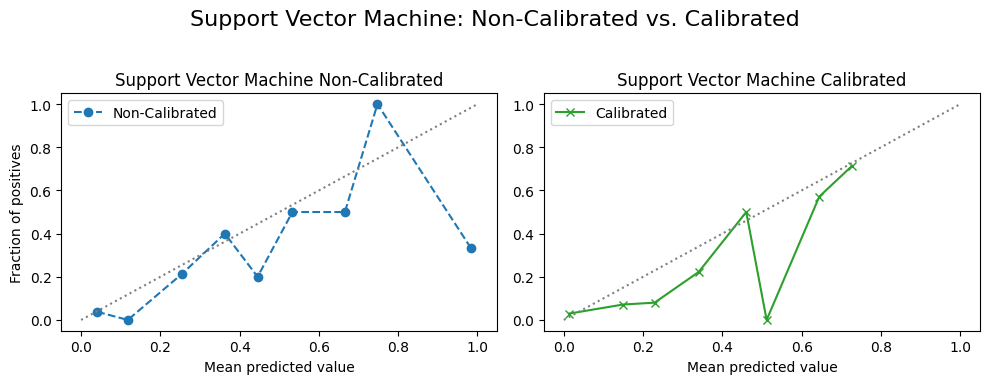

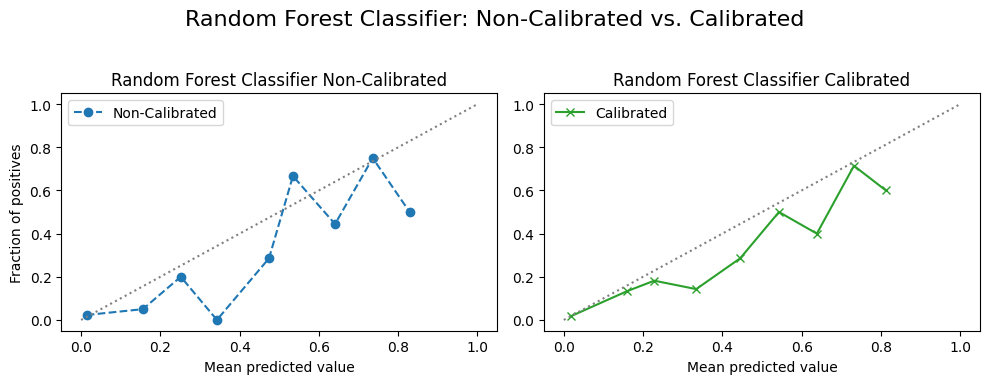

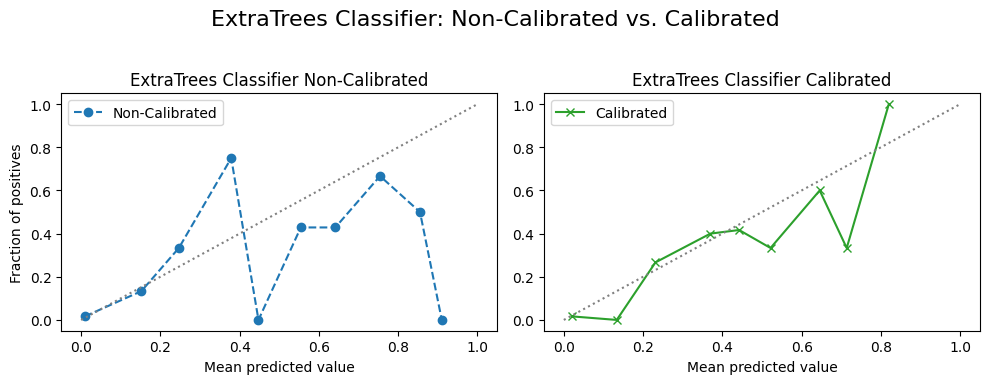

In [18]:
custom_titles = {
    "grid_search_lr": "Logistic Regression",
    "grid_search_svm": "Support Vector Machine",
    "grid_search_rf": "Random Forest Classifier",
    "grid_search_et": "ExtraTrees Classifier",
}

# Loop through each model to create a side-by-side plot for non-calibrated and
# calibrated models
for name, model in model_list:
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(10, 4)
    )  # figsize adjusted for two subplots side by side

    # Non-Calibrated Model
    prob_true_non_calib, prob_pred_non_calib = calibration_curve(
        y_test,
        non_calibrated_probas_dict[f"{name}_proba"],
        n_bins=10,
        strategy="uniform",
    )
    ax1.plot(
        prob_pred_non_calib,
        prob_true_non_calib,
        marker="o",
        linestyle="--",
        color="tab:blue",
        label="Non-Calibrated",
    )
    ax1.plot([0, 1], [0, 1], linestyle=":", color="gray")
    ax1.set_title(f"{custom_titles[name]} Non-Calibrated")  # Use custom title
    ax1.set_xlabel("Mean predicted value")
    ax1.set_ylabel("Fraction of positives")
    ax1.legend()

    # Calibrated Model
    prob_true_calib, prob_pred_calib = calibration_curve(
        y_test, probas_dict[f"{name}_proba"], n_bins=10, strategy="uniform"
    )
    ax2.plot(
        prob_pred_calib,
        prob_true_calib,
        marker="x",
        linestyle="-",
        color="tab:green",
        label="Calibrated",
    )
    ax2.plot([0, 1], [0, 1], linestyle=":", color="gray")
    ax2.set_title(f"{custom_titles[name]} Calibrated")  # Use custom title
    ax2.set_xlabel("Mean predicted value")
    ax2.legend()

    fig.suptitle(f"{custom_titles[name]}: Non-Calibrated vs. Calibrated", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(image_path, "non_calibrated_vs_calibrated.svg"))
    plt.show()

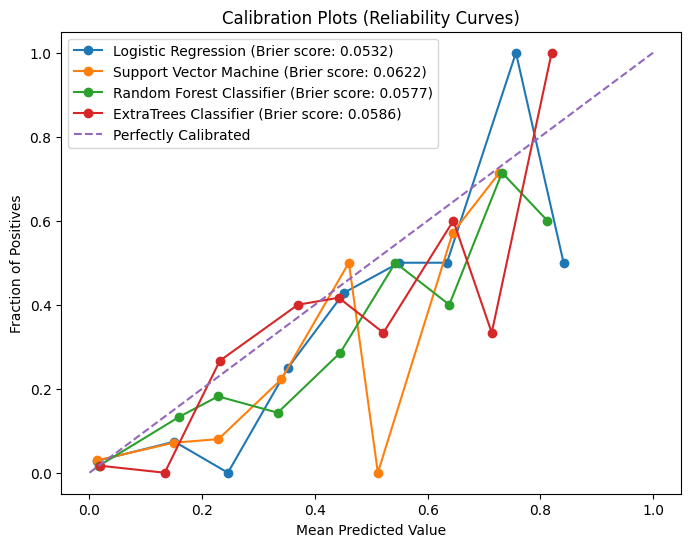

{'Logistic Regression': 0.05321798655726836,
 'Support Vector Machine': 0.06215359738495616,
 'Random Forest Classifier': 0.05768582367194654,
 'ExtraTrees Classifier': 0.058574661633233945}

In [19]:
model_dict = {
    "Logistic Regression": probas_dict["grid_search_lr_proba"],
    "Support Vector Machine": probas_dict["grid_search_svm_proba"],
    "Random Forest Classifier": probas_dict["grid_search_rf_proba"],
    "ExtraTrees Classifier": probas_dict["grid_search_et_proba"],
}

plot_calibration_curves(y_true=y_test, model_dict=model_dict, image_path=image_path, img_string="calibration_curves.svg",)

## Performance Assessment

### AUC ROC Curves by Model

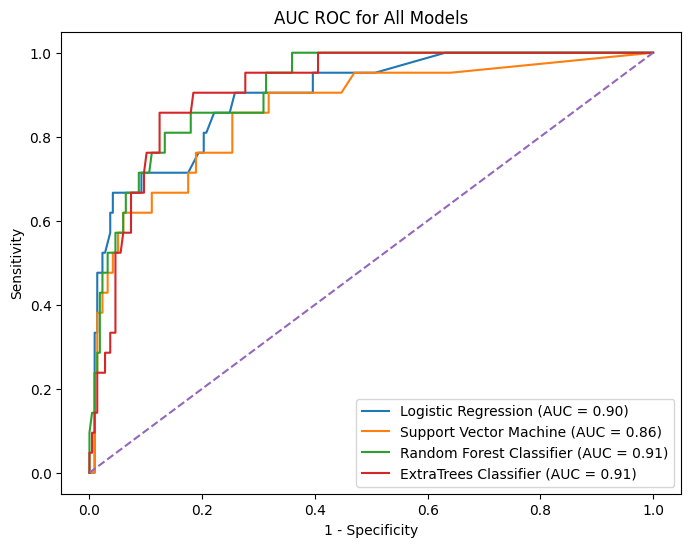

In [27]:
plt.figure(figsize=(8,6))
for name, proba in model_dict.items():
    fpr, tpr, _ = roc_curve(y_test, proba)  # calculate values for TPR, FPR
    auc_models = auc(fpr, tpr)  # calculate the auc for all models
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_models:.2f})")  # plot the ROC AUC

plt.plot([0, 1], [0, 1], "--")
plt.title("AUC ROC for All Models")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.legend()
plt.savefig(os.path.join(image_path, "roc_auc_models.svg"))
plt.show()

In [21]:
metrics_df = evaluate_model_metrics(y_test=y_test, model_dict=model_dict, threshold=0.5)
metrics_df

Metric,Logistic Regression,Support Vector Machine,Random Forest Classifier,ExtraTrees Classifier,Best Model
AUC ROC,0.897520,0.863178,0.913978,0.914088,ExtraTrees Classifier
PR AUC,0.500029,0.431027,0.557629,0.466860,Random Forest Classifier
Precision,0.666667,0.562500,0.578947,0.466667,Logistic Regression
Recall,0.476190,0.428571,0.523810,0.333333,Random Forest Classifier
Specificity,0.976959,0.967742,0.963134,0.963134,Logistic Regression
Average Precision,0.520694,0.466152,0.563493,0.484984,Random Forest Classifier
Brier Score,0.053218,0.062154,0.057686,0.058575,Logistic Regression


### AUC ROC Curves by Feature

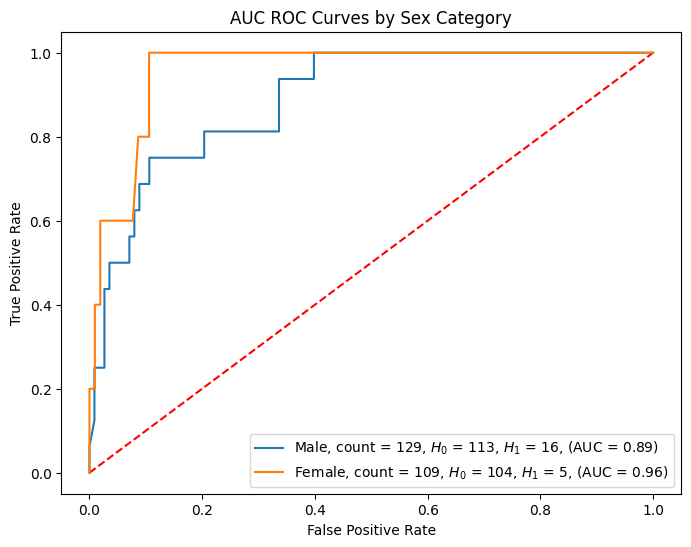

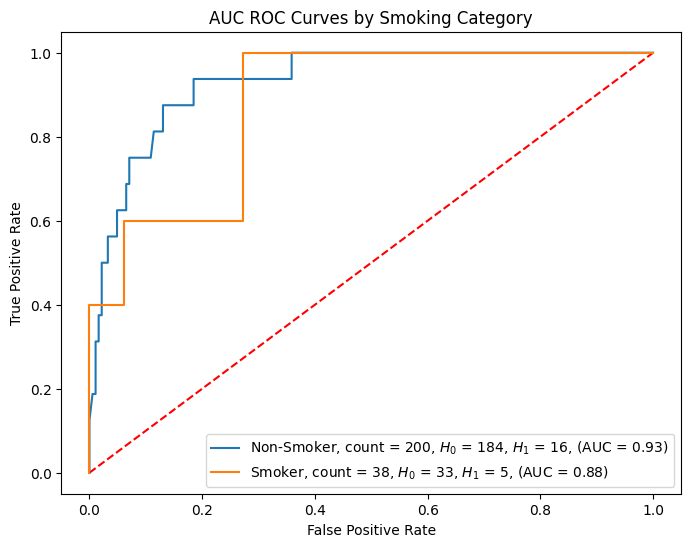

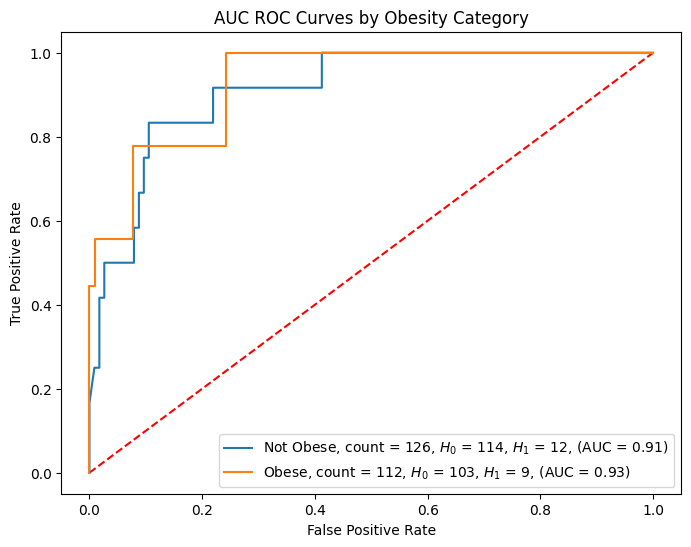

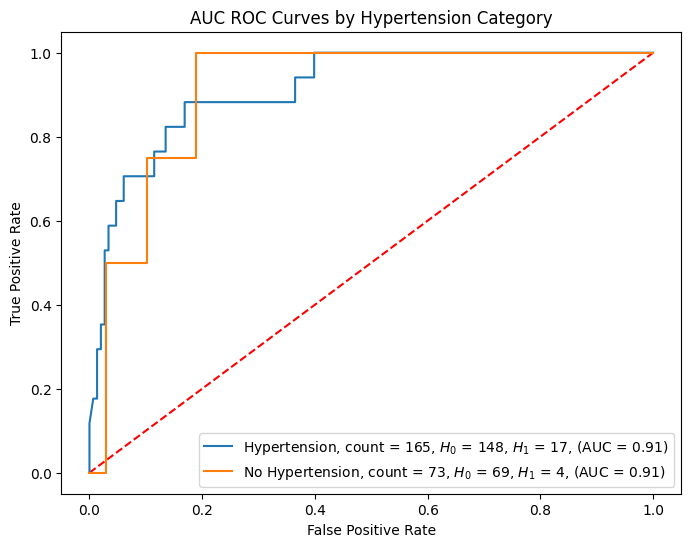

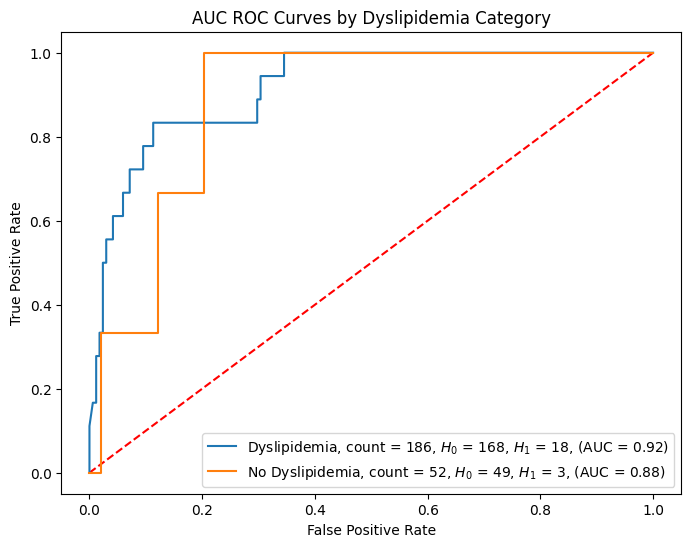

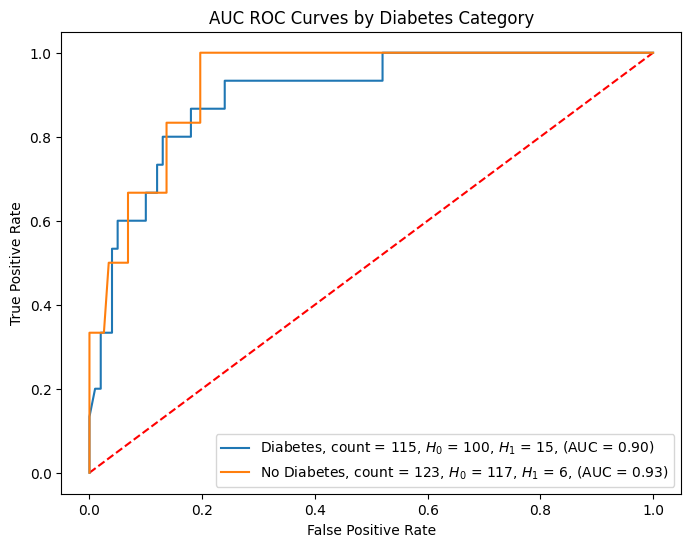

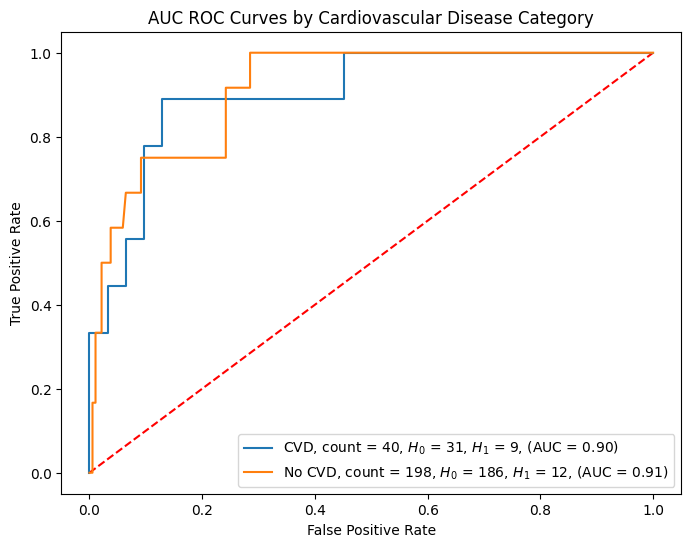

In [29]:
# Dictionary of model predictions, assuming 'probas_dict' is defined
model_predictions = probas_dict["grid_search_rf_proba"]

# Dictionary of custom category labels for each column
# This assumes you have predefined labels for each category in your features
category_label_dict = {
    "sex": {1: "Male", 0: "Female"},
    "smoking": {1: "Smoker", 0: "Non-Smoker"},
    "obesity": {1: "Obese", 0: "Not Obese"},
    "hypertension": {1: "Hypertension", 0: "No Hypertension"},
    "dyslipidemia": {1: "Dyslipidemia", 0: "No Dyslipidemia"},
    "diabetes": {1: "Diabetes", 0: "No Diabetes"},
    "cardiovascular_disease": {1: "CVD", 0: "No CVD"}

    # Add more feature_label pairs as needed
}

# Loop over each feature you want to create a ROC plot for

for feature, category_labels in category_label_dict.items():
    title = f"AUC ROC Curves by {feature.replace('_', ' ').title()} Category"
    plt.figure(figsize=(8,6))
    plot_roc_curves_by_category(
        X_test=X_test,
        y_test=y_test,
        predictions=model_predictions,
        feature=feature,
        category_labels=category_labels,
        outcome="outcome",
        title=title,
        image_path=image_path,
        img_string=f"auc_roc_by_{feature}.svg",
    )


## Save Best Model's Predictions

In [23]:
model_df = pd.DataFrame(index=X_test.index)

# Add the scores to the DataFrame
for name, values in probas_dict.items():
    if name.endswith("_score"):
        model_df[name] = values
    elif name.endswith("_proba"):
        model_df[name] = values

In [24]:
pd.DataFrame(model_df["grid_search_rf_score"]).to_parquet(
    os.path.join(data_original, "rf_score.parquet")
)

## References

Al-Shamsi, S., Govender, R. D., & King, J. (2021). Predictive value of creatinine-based equations of kidney function in the long-term prognosis of United Arab Emirates patients with vascular risk. *Oman medical journal, 36*(1), e217. https://doi.org/10.5001/omj.2021.07


Al-Shamsi, S., Govender, R. D., & King, J. (2019). Predictive value of creatinine-based equations of kidney function in the long-term prognosis of United Arab Emirates patients with vascular risk [Dataset]. Mendeley Data, V1. https://data.mendeley.com/datasets/ppfwfpprbc/1



